# THIS NOTEBOOK TRAINS A FASHION-MNIST MODEL USING 0-255 VALUES (UINT8)

> Note that the end model, oexported in a FINN-ONNX format will be Quantized. Quantization is handled by Brevitas.

After creating the docker environement,

The goal is to create a MNIST Fasion model in pytorch and experiment with the different parameters

Then, we will do the same model but fully quantized and start adapting it for FINN

> Side note : We'll use Quantization Aware Training (QAT) for this tutorial, but another possibility is to use Post-Training Quantization (PTQ) [Here is a resource to learn more but it's not really necessary for this tutorial](https://www.youtube.com/watch?v=0VdNflU08yA) 

## Base model creation

Before going anyfurther, note that this notebook was meant to be run in the FINN docker environment, from a linux host.

Use the command ```bash run-docker.sh notbook``` and use the jupyter link for your vscode/vim editor or simply open it in your browser if you like jupyter you will also need to setup you env variables right.

I encourage you to check the FINN docs for this part, you can find more precise guidelines in the resources of the main [readme](./README.md).

> Don't forget to use your own username below. ```root_dir = f"/tmp/finn_dev_{user_name}"``` is the common mounted folder where you'll be able to access all outputs from the FINN docker container from you host machine to then use it for further treatment.

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

user_name = "rootmin" # REPLACE THIS WITH YOUR HOST MACHINE USER NAME 
root_dir = f"/tmp/finn_dev_{user_name}"

print(root_dir)

/tmp/finn_dev_rootmin


Import the data and transform it, we don't normalize to really make it as simple as possible, the only transformation is to convert it to a pytorch tensor.

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    #transforms.Normalize((0.5,), (0.5,))  # Normalize the tensor with mean and std
]);

# Load the training dataset
train_dataset = datasets.FashionMNIST(
    root='./data',  # Directory to save the dataset
    train=True,  # Load the training set
    download=True,  # Download the dataset if it doesn't exist
    transform=transform  # Apply the defined transformations
);

# Load the test dataset
test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,  # Load the test set
    download=True,
    transform=transform
);

Let's visualize the data a little bit... We see the data is ranging from 0 to 1 but we know our FPGA AI model IP will expect INTEGER values... More on that later !

Min :  0.0  /// Max :  0.78039217
Data type : float32


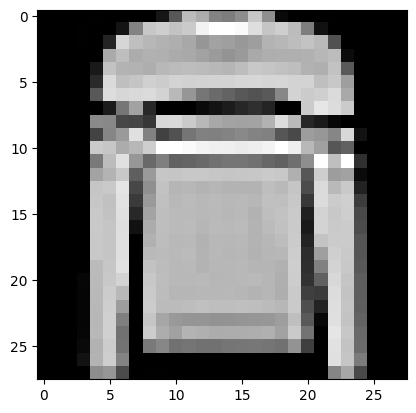

In [4]:
import matplotlib.pyplot as plt
import numpy as np

image, label = train_dataset[5]
image = np.array(image).squeeze()
print("Min : ", np.min(image[0]), " /// Max : ", np.max(image[0]))
print("Data type :", image[0].dtype)
# plot the sample

fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

# Actual QNN

> QNN = Quantized Neural Network

That's what we are about to do using Quantized Aware Training, and the best part is Brevitas handles all of it in the background !

This part is about creating a quantized version of the model and adapting it to finn.

In [5]:
import torch
from brevitas.nn import QuantLinear
from brevitas.nn import QuantReLU

import torch.nn as nn

brevitas_input_size = 28 * 28
brevitas_hidden1 = 64
brevitas_hidden2 = 64
brevitas_num_classes = 10
weight_bit_width = 4
act_bit_width = 4
dropout_prob = 0.5

#is this model fully quantized or only the wieghts, i shall dig to find out once done !
brevitas_model = nn.Sequential(
    QuantLinear(brevitas_input_size, brevitas_hidden1, bias=True, weight_bit_width=weight_bit_width),
    nn.BatchNorm1d(brevitas_hidden1),
    nn.Dropout(0.5),
    QuantReLU(bit_width=act_bit_width),
    QuantLinear(brevitas_hidden1, brevitas_hidden2, bias=True, weight_bit_width=weight_bit_width),
    nn.BatchNorm1d(brevitas_hidden2),
    nn.Dropout(0.5),
    QuantReLU(bit_width=act_bit_width),
    QuantLinear(brevitas_hidden2, brevitas_num_classes, bias=True, weight_bit_width=weight_bit_width),
    QuantReLU(bit_width=act_bit_width)
)

# uncomment to check the network object
# brevitas_model

### The input data has to be quantized.

Normaly in brevistas, we can use the ```QuantIdentity()``` layer for this but unfortunatly, it does not convert to hardware (yet) in FINN.

It its really not a problem, as we can just quantize the input data !

In [6]:
from torch.utils.data import Dataset

# Define a custom quantization function
def quantize_tensor(x, num_bits=8):
    qmin = 0.
    qmax = 2.**num_bits - 1.
    min_val, max_val = x.min(), x.max()

    scale = (max_val - min_val) / (qmax - qmin)
    initial_zero_point = qmin - min_val / scale

    zero_point = 0
    if initial_zero_point < qmin:
        zero_point = qmin
    elif initial_zero_point > qmax:
        zero_point = qmax
    else:
        zero_point = initial_zero_point

    zero_point = int(zero_point)
    q_x = zero_point + x / scale
    q_x.clamp_(qmin, qmax).round_()
    
    return q_x

# Define the quantized transform
transform_quantized = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Lambda(lambda x: quantize_tensor(x))  # Apply quantization
])

# Load the training dataset
train_dataset_qnt = datasets.FashionMNIST(
    root='./data',  # Directory to save the dataset
    train=True,  # Load the training set
    download=True,  # Download the dataset if it doesn't exist
    transform=transform_quantized  # Apply the defined transformations
);

# Load the test dataset
test_dataset_qnt = datasets.FashionMNIST(
    root='./data',
    train=False,  # Load the test set
    download=True,
    transform=transform_quantized
)

train_loader = DataLoader(train_dataset_qnt, 100)
test_loader = DataLoader(test_dataset_qnt, 100)

Let's re-visualize the data now... That's better !!

Min :  0.0  /// Max :  255.0
float32


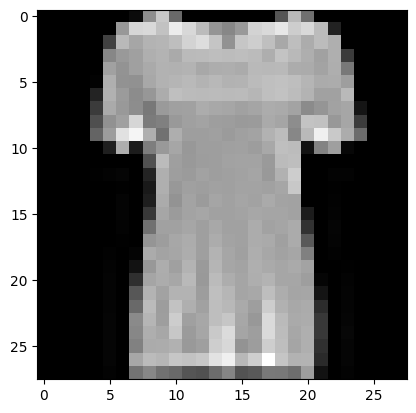

In [8]:
import matplotlib.pyplot as plt
import numpy as np

image, label = train_dataset_qnt[10]
image = np.array(image).squeeze()
print("Min : ", np.min(image), " /// Max : ", np.max(image))
print(image.dtype)

# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

## Actual training

Now, just like in a regular PyTorch workflow, we train the model using a simple trainng loop.

Note that it takes a bit of time because
- We train on CPU
- QAT "simulates" Quantization using quant/dequant layers (so the model becomes robust to quantization, which is not the case in PTQ) and backpropagation is different and that takes up computing power

In [9]:
# loss criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(brevitas_model.parameters(), lr=0.001, betas=(0.9, 0.999))

num_epochs = 5
brevitas_model.train()
batch_size = 100

for epoch in range(num_epochs):
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = torch.reshape(images, (batch_size, 28*28))
        out = brevitas_model(images.float()) # This just make the value a float ie 255 becomes 255,0 and not 1
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/5], Loss: {loss.item():.4f}')

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1255: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1758.)
  return super(Tensor, self).rename(names)


Epoch [1/5], Loss: 0.6401
Epoch [2/5], Loss: 0.4895
Epoch [3/5], Loss: 0.5153
Epoch [4/5], Loss: 0.6120
Epoch [5/5], Loss: 0.3428


We now test the model with ~85% accuracy, which is extremely close to non-quatized model performances (~85-86% when I tested it on my side when I made the course).

This dataset isn't very complex though, this delta will depend on the data you have to classify.

In [10]:
# test the model

brevitas_model.eval()
correct = 0
total = 0
loss_total = 0

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        images = torch.reshape(images, (batch_size, 28*28))
        out = brevitas_model(images.float())
        _, predicted = torch.max(out.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print("accuracy =", accuracy, "%")

accuracy = 84.2 %


Here are some lines to execute the tensor that mmakes up the model and their different representations :

In [11]:
#lets have a quick look at the weights too
print(brevitas_model[0].quant_weight())
#internally, weoght are stored as float 32, here nare ways to visualize actual quantized weights :
print(brevitas_model[0].quant_weight().int())
print(brevitas_model[0].quant_weight().int().dtype)

QuantTensor(value=tensor([[ 0.0294, -0.0000,  0.0589,  ..., -0.0589,  0.0589,  0.0883],
        [ 0.0294,  0.0000,  0.0294,  ..., -0.0883, -0.1471, -0.0589],
        [-0.0589,  0.0294, -0.0294,  ...,  0.0883,  0.0883, -0.1177],
        ...,
        [ 0.0589,  0.0883, -0.0294,  ..., -0.0589, -0.0000,  0.0589],
        [ 0.0589, -0.0000, -0.0294,  ...,  0.0000,  0.0294, -0.0294],
        [-0.0294,  0.0000, -0.0589,  ...,  0.0000,  0.0294, -0.0294]],
       grad_fn=<MulBackward0>), scale=tensor(0.0294, grad_fn=<DivBackward0>), zero_point=tensor(0.), bit_width=tensor(4.), signed_t=tensor(True), training_t=tensor(False))
tensor([[ 1,  0,  2,  ..., -2,  2,  3],
        [ 1,  0,  1,  ..., -3, -5, -2],
        [-2,  1, -1,  ...,  3,  3, -4],
        ...,
        [ 2,  3, -1,  ..., -2,  0,  2],
        [ 2,  0, -1,  ...,  0,  1, -1],
        [-1,  0, -2,  ...,  0,  1, -1]], dtype=torch.int8)
torch.int8


# EXPORTING THE MODEL TO FINN-ONNX

maybe you know ONNX, maybe you don't. At the end of the day, It's just a way to represent AI models (or just tensor operations) in an optimised an standard way. It also allows us to use Netron to visualize the model as a nice graph.

> FINN-ONNX is just like ONNX, exept it's better for quantized models (under 8bit quantization).

In [12]:
from brevitas.export import export_qonnx
from qonnx.util.cleanup import cleanup as qonnx_cleanup
from qonnx.core.modelwrapper import ModelWrapper
from qonnx.core.datatype import DataType
from finn.transformation.qonnx.convert_qonnx_to_finn import ConvertQONNXtoFINN

filename = root_dir + "/part1.onnx"
filename_clean = root_dir + "/part1_clean.onnx"

def asymmetric_quantize(arr, num_bits=8):
    min = 0
    max = 2**num_bits - 1
    
    beta = np.min(arr)
    alpha = np.max(arr)
    scale = (alpha - beta) / max
    zero_point = np.clip((-beta/scale),0,max).round().astype(np.int8)

    quantized_arr = np.clip(np.round(arr / scale + zero_point), min, max).astype(np.float32)
    
    return quantized_arr

#Crete a tensor ressembling the input tensor we saw earlier
input_a = np.random.rand(1,28*28).astype(np.float32)
input_a = asymmetric_quantize(input_a)
print(np.max(input_a[0]))
scale = 1.0
input_t = torch.from_numpy(input_a * scale)

# Export to ONNX
export_qonnx(
    brevitas_model, export_path=filename, input_t=input_t
)

# clean-up
qonnx_cleanup(filename, out_file=filename_clean)

# ModelWrapper
model = ModelWrapper(filename_clean)
model = model.transform(ConvertQONNXtoFINN())
model.save(root_dir + "/ready_finn.onnx")

print("Model saved to " + root_dir + "/ready_finn.onnx")

255.0
Model saved to /tmp/finn_dev_rootmin/ready_finn.onnx


/home/rootmin/Documents/freelance/mission2/finn/deps/qonnx/src/qonnx/transformation/gemm_to_matmul.py:57: UserWarning: The GemmToMatMul transformation only offers explicit support for version 9 of the Gemm node, but the ONNX version of the supplied model is 14. Thus the transformation may fail or return incomplete results.
  warnings.warn(


## Visualization in Netron

We can now visualise our network in netron, we can clearly identify each layer in this graph, Great !

In [13]:
from finn.util.visualization import showInNetron

showInNetron(root_dir + "/ready_finn.onnx")

Serving '/tmp/finn_dev_rootmin/ready_finn.onnx' at http://0.0.0.0:8081


We are now ready to move on to FINN !